In [6]:
from pyqode.utils import psi_to_pa, r_to_k, radius_to_area
from frog.doe import DoEGenerator, DoERunner
from skopt.sampler import Lhs
from skopt.space import Space
import numpy as np
ffrom pyqode.solver import SU2Solver, Solver
rom backnozzle.cad import BackNozzleCAD
import pandas as pd
import ray

In [7]:
def run_2D(config):
    nozzle = BackNozzleCAD(
        divergence_angle=config['divergence_angle'],
        throat_radius=config['throat_radius'],
    )

    points = nozzle.get_points(config['domain_Nx'])
    xn, rn = points[:, 0], points[:, 1]

    config['domain_x'] = xn
    config['domain_area'] = radius_to_area(rn)

    su2 = SU2Solver(config=config)
    su2.run()

    return su2.check_convergence()

def run_1D(config):
    nozzle = BackNozzleCAD(
        divergence_angle=config['divergence_angle'],
        throat_radius=config['throat_radius'],
    )

    points = nozzle.get_points(config['domain_size'])
    xn, rn = points[:, 0], points[:, 1]

    config['domain_x'] = xn
    config['domain_area'] = radius_to_area(rn),

    q1d = Solver(config = config)
    q1d.run()

    

    return q1d.check_convergence()

In [8]:
variables = {
    'bc_p0' : (psi_to_pa(45.1), psi_to_pa(250.2)),          #P0IN
    'bc_T0' : (r_to_k(530.0), r_to_k(1500.0)),              #T0IN
    'divergence_angle' : (10.0, 20.0),                                 #DIVERGENCE ANGLE
    'bc_Tw' : (0.4*r_to_k(530), 0.65*r_to_k(1500.0))        #WALL TEMPERATURE]
}

other_variables_1D = {
    #'divergence_angle' : 15.0,
    'working_dir': './data/1D',
    'domain_size': 100,
    'bc_M': 0.0001,
    'bc_pb': 101325,
    'fluid_R': 287.0,
    'fluid_gamma': 1.35,
    'solver_itmax': 50000,
    'solver_itprint': 1,
    'solver_CFL': 0.1,
    'solver_tol': 1e-8,
    'solver_tscheme': 'Euler',
    'solver_fscheme': 'AUSM',
    'solver_dttype': 'Global',
    'solver_dim': 'Dimensionless',  
    'throat_radius': 20.32,
}

other_variables_2D = {
    'working_dir': './data/2D',
    'su2_template': './data/template_su2.cfg',
    'su2_config': 'fluid.cfg',
    'domain_axisymmetric': 'YES',
    'domain_Nx': 100+1,
    'domain_Ny': 18+1,
    'domain_inflation_rate': 1.00,
    'domain_bl_beta': 1.001,
    'domain_bl_nblayers': 7,
    'domain_hwall_n': 0.01,
    'domain_mesh' : f'./mesh/nozzle.su2',
    'turbulence_model': 'SST',
    'solver_dim': 'FREESTREAM_PRESS_EQ_ONE',
    'fluid': 'STANDARD_AIR',
    'fluid_gamma': 1.35,
    'fluid_R': 287.0,
    'fluid_critical_temperature': 131.00,
    'fluid_critical_pressure': 3588550.0,
    'fluid_accentric_factor': 0.035,
    'fluid_viscosity_model': 'SUTHERLAND', 
    'fluid_sutherland_viscosity': 1.716E-5,
    'fluid_sutherland_temperature': 273.15,
    'fluid_sutherland_constant': 110.4,
    'fluid_conductivity_model': 'CONSTANT_PRANDTL',
    'fluid_laminar_prandtl': 0.72,
    'fluid_turbulent_prandtl': 0.9,
    'solver_CFL': 0.01,
    'bc_M': 0.0001,
    'bc_pb': 101325,
    'solver_itmax': 100,
    'solver_tol': np.log10(1e-8),
    'solver_tscheme': 'EULER_IMPLICIT',
    'solver_fscheme': 'JST_KE',
    'solver_dttype': 'Global',
    'output_files': 'PARAVIEW',
    'throat_radius': 20.32  
}

In [9]:
variables

{'bc_p0': (310953.67600000004, 1725068.952),
 'bc_T0': (294.44444444444446, 833.3333333333333),
 'divergence_angle': (10.0, 20.0),
 'bc_Tw': (117.77777777777779, 541.6666666666666)}

In [10]:
doe_generator = DoEGenerator(
    variables = variables,
    sampler = Lhs(lhs_type="classic", criterion="maximin", iterations=10000),
    n_samples = 100,
)

doe_generator.save('./data/doe_lhs.csv')

KeyError: 'working_dir'

In [41]:
full_df = doe_generator.fdf

In [42]:
#jobs = []
#for i in range(len(full_df)):
#    jobs.append(run_1D_remote.remote(full_df.iloc[i].to_dict()))

#results = ray.get(jobs)

In [43]:
doe_runner_1D = DoERunner(
    file='./data/doe_lhs.csv', 
    other_variables = other_variables_1D,
    function = run_1D,
    log_file = './data/doe_lhs_1D_log.csv'
)

doe_runner_2D = DoERunner(
    file='./data/doe_lhs.csv', 
    other_variables = other_variables_2D,
    function = run_2D,
    log_file = './data/doe_lhs_2D_log.csv'
)

In [44]:
doe_runner_1D.df

,bc_p0,bc_T0,divergence_angle,bc_Tw,status
design_point,,,,,
0,7.477299e+05,537.061889,15.954599,200.960548,pending
1,1.550222e+06,810.973314,14.369437,227.084879,pending
2,5.370202e+05,309.806944,18.692557,290.734773,pending
3,1.164865e+06,611.106086,12.700770,414.811715,pending
4,8.778069e+05,768.185327,12.278904,425.736520,pending
...,...,...,...,...,...
95,5.154299e+05,709.133438,10.707831,430.226318,pending
96,6.854974e+05,482.140312,16.898766,356.760153,pending
97,1.049738e+06,618.896005,13.758066,369.642827,pending


In [45]:
doe_runner_1D.run_parallel()

2023-11-14 09:40:37,582	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


(remote_function pid=2338424) ################################################################################
(remote_function pid=2338424)                            -*- Q1D Euler Solver -*-
(remote_function pid=2338424) Eigen 3.3.7
(remote_function pid=2338424) Allan Moreira de Carvalho
(remote_function pid=2338424) ################################################################################
(remote_function pid=2338424)                            -*- Setup Information -*-
(remote_function pid=2338424) ################################################################################
(remote_function pid=2338424) # Domain x-coordinates at cell faces (no need for ghost cells)
(remote_function pid=2338424) /home/ppiper/Dropbox/xps/doctorate/repositories/frog/examples/data/1D/5/inputs/xn.txt
(remote_function pid=2338424) # Area distributuin at cell faces (no need for ghost cells)
(remote_function pid=2338424) /home/ppiper/Dropbox/xps/doctorate/repositories/frog/examples/data/1D/5/inp

2023-11-14 09:40:46,150	WARNING worker.py:823 -- The driver may not be able to keep up with the stdout/stderr of the workers. To avoid forwarding logs to the driver, use 'ray.init(log_to_driver=False)'.


(remote_function pid=2338443) ################################################################################ [repeated 147x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(remote_function pid=2338433)                            -*- Q1D Euler Solver -*- [repeated 23x across cluster]
(remote_function pid=2338433) Eigen 3.3.7 [repeated 23x across cluster]
(remote_function pid=2338433) Allan Moreira de Carvalho [repeated 23x across cluster]
(remote_function pid=2338433)                            -*- Setup Information -*- [repeated 23x across cluster]
(remote_function pid=2338433) # Domain x-coordinates at cell faces (no need for ghost cells) [repeated 23x across cluster]
(remote_function pid=2338447) 2025		0.00123178	0.000414591	0.00429031 [repeated 357151x across cluster]
(remote_function pid=2338433) # Area distributuin at 

2023-11-14 09:40:52,771	WARNING worker.py:823 -- The driver may not be able to keep up with the stdout/stderr of the workers. To avoid forwarding logs to the driver, use 'ray.init(log_to_driver=False)'.


(remote_function pid=2338442)                            -*- Saving Results -*- [repeated 36x across cluster]
(remote_function pid=2338442) runtime: 1.6267038579971995s [repeated 37x across cluster]


2023-11-14 09:40:54,578	WARNING worker.py:823 -- The driver may not be able to keep up with the stdout/stderr of the workers. To avoid forwarding logs to the driver, use 'ray.init(log_to_driver=False)'.


(remote_function pid=2338440) 12315		1.04239e-07	1.5361e-07	3.79483e-07
(remote_function pid=2338440) 12316		1.03284e-07	1.53923e-07	3.75572e-07
(remote_function pid=2338440) 12317		1.02326e-07	1.5423e-07	3.71655e-07
(remote_function pid=2338440) 12318		1.01367e-07	1.54533e-07	3.6773e-07
(remote_function pid=2338440) 12319		1.00406e-07	1.54831e-07	3.63799e-07
(remote_function pid=2338440) 12320		9.94432e-08	1.55124e-07	3.59862e-07
(remote_function pid=2338440) 12321		9.84783e-08	1.55411e-07	3.55918e-07
(remote_function pid=2338440) 12322		9.75115e-08	1.55694e-07	3.51968e-07
(remote_function pid=2338440) 12323		9.65428e-08	1.55972e-07	3.48012e-07
(remote_function pid=2338440) 12324		9.55724e-08	1.56245e-07	3.4405e-07
(remote_function pid=2338440) 12325		9.46001e-08	1.56512e-07	3.40081e-07
(remote_function pid=2338440) 12326		9.36261e-08	1.56775e-07	3.36108e-07
(remote_function pid=2338440) 12327		9.26504e-08	1.57033e-07	3.32128e-07
(remote_function pid=2338440) 12328		9.1673e-08	1.57286

In [46]:


#result_ids = [run_1D_parallel.remote(x) for x in range(20)]

#while len(result_ids):
#    done_id, result_ids = ray.wait(result_ids)

(remote_function pid=2338449) 11101		2.94544e-07	2.56496e-07	1.10814e-06
(remote_function pid=2338449) 11102		2.9267e-07	2.5755e-07	1.10058e-06
(remote_function pid=2338449) 11103		2.9079e-07	2.58594e-07	1.09301e-06
(remote_function pid=2338449) 11104		2.88902e-07	2.5963e-07	1.0854e-06
(remote_function pid=2338449) 11105		2.87008e-07	2.60657e-07	1.07778e-06
(remote_function pid=2338449) 11106		2.85108e-07	2.61675e-07	1.07013e-06
(remote_function pid=2338449) 11107		2.83201e-07	2.62684e-07	1.06245e-06
(remote_function pid=2338449) 11108		2.81288e-07	2.63684e-07	1.05476e-06
(remote_function pid=2338449) 11109		2.79368e-07	2.64674e-07	1.04704e-06
(remote_function pid=2338449) 11110		2.77442e-07	2.65656e-07	1.03929e-06
(remote_function pid=2338449) 11111		2.7551e-07	2.66628e-07	1.03153e-06
(remote_function pid=2338449) 11112		2.73572e-07	2.67592e-07	1.02374e-06
(remote_function pid=2338449) 11113		2.71627e-07	2.68546e-07	1.01593e-06
(remote_function pid=2338449) 11114		2.69677e-07	2.69491e

In [47]:
#doe_runner_1D.save('./data/doe_lhs_1D_log.csv')

(remote_function pid=2338453) 8839		2.77145e-06	8.04254e-07	8.07721e-06
(remote_function pid=2338453) 8840		2.78184e-06	8.01334e-07	8.1026e-06
(remote_function pid=2338453) 8841		2.79214e-06	7.98393e-07	8.12773e-06
(remote_function pid=2338453) 8842		2.80236e-06	7.95431e-07	8.1526e-06
(remote_function pid=2338453) 8843		2.81248e-06	7.92448e-07	8.17721e-06
(remote_function pid=2338453) 8844		2.82251e-06	7.89445e-07	8.20156e-06
(remote_function pid=2338453) 8845		2.83245e-06	7.86421e-07	8.22564e-06
(remote_function pid=2338453) 8846		2.84229e-06	7.83377e-07	8.24947e-06
(remote_function pid=2338453) 8847		2.85205e-06	7.80312e-07	8.27303e-06
(remote_function pid=2338453) 8848		2.86171e-06	7.77227e-07	8.29633e-06
(remote_function pid=2338453) 8849		2.87128e-06	7.74122e-07	8.31937e-06
(remote_function pid=2338453) 8850		2.88076e-06	7.70997e-07	8.34215e-06
(remote_function pid=2338453) 8851		2.89015e-06	7.67852e-07	8.36466e-06
(remote_function pid=2338453) 8852		2.89944e-06	7.64687e-07	8.3869

(remote_function pid=2338445) ################################################################################
(remote_function pid=2338445)                            -*- Saving Results -*-
(remote_function pid=2338445) ################################################################################


(remote_function pid=2338445) runtime: 0.6730023239942966s
(remote_function pid=2338443)                            -*- Q1D Euler Solver -*-
(remote_function pid=2338443) Eigen 3.3.7
(remote_function pid=2338443) Allan Moreira de Carvalho
(remote_function pid=2338443)                            -*- Setup Information -*-
(remote_function pid=2338443) # Domain x-coordinates at cell faces (no need for ghost cells)
(remote_function pid=2338443) # Area distributuin at cell faces (no need for ghost cells)
(remote_function pid=2338443) # Inlet Total Pressure [Pa]
(remote_function pid=2338443) # Inlet Total Temperature [K]
(remote_function pid=2338443) # Inlet Mach Number
(remote_function pid=2338443) # Outlet Static Pressure [Pa]
(remote_function pid=2338443) # Gas constant [J/kg/K]
(remote_function pid=2338443) # Specific heat ratio
(remote_function pid=2338443) # Maximum number of iterations 
(remote_function pid=2338443) # Interval to print iterations 
(remote_function pid=2338443) # CFL n

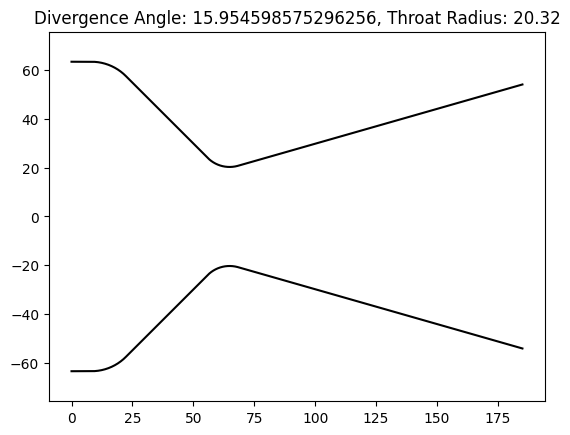

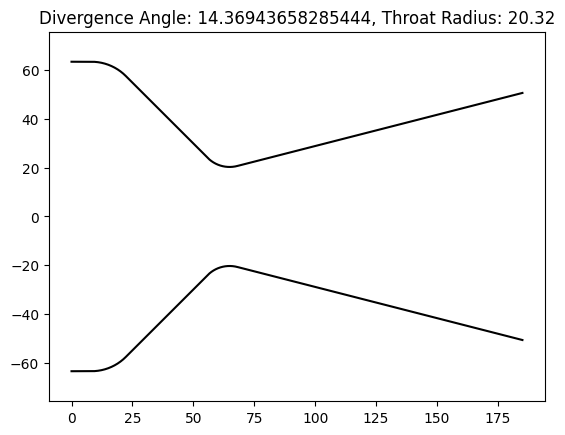

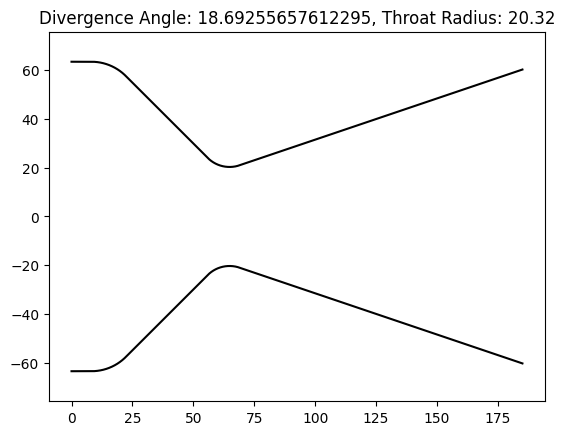

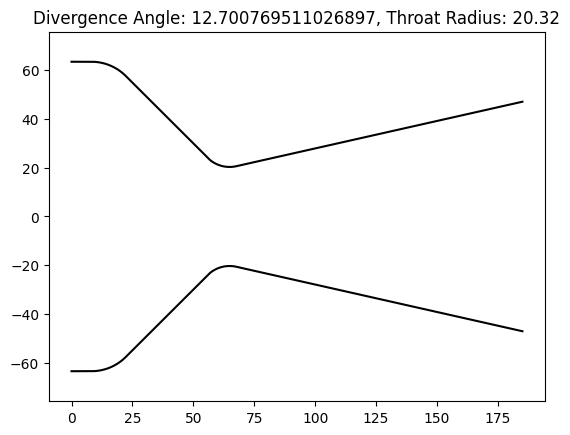

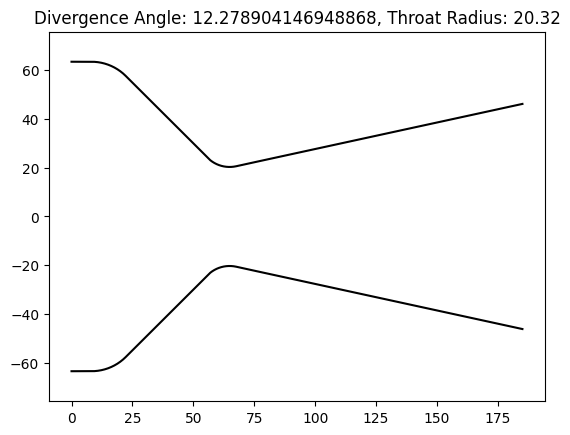

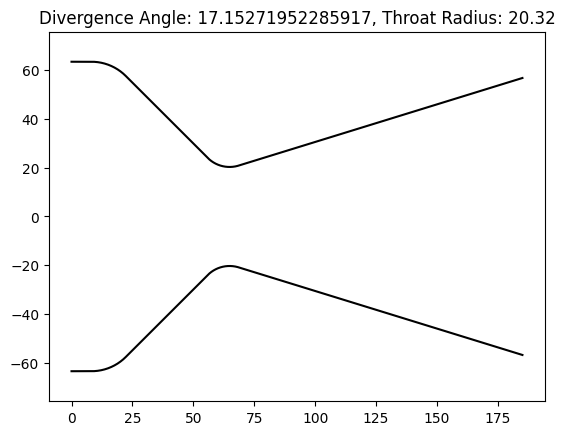

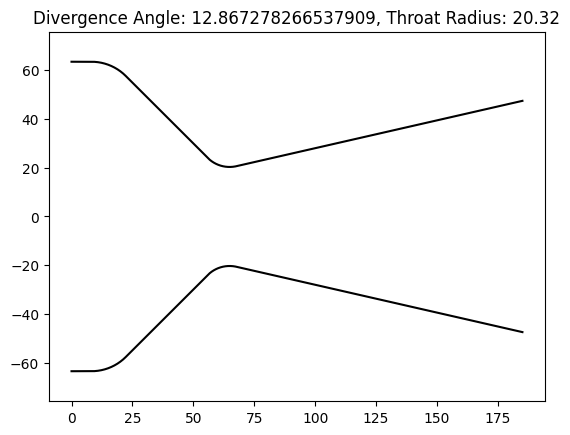

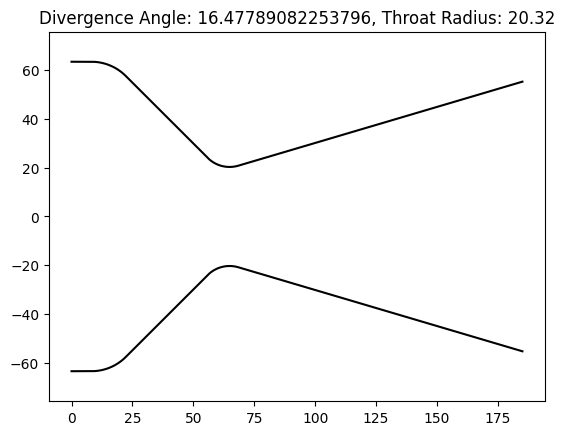

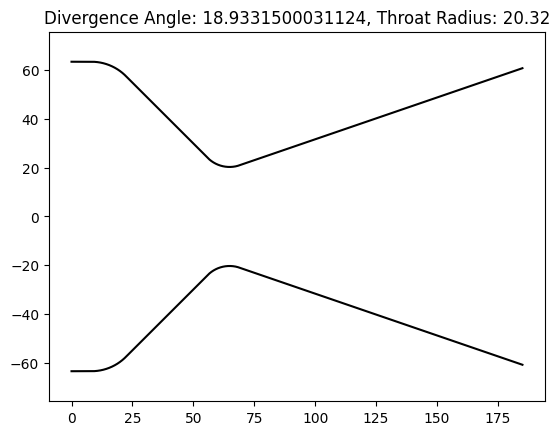

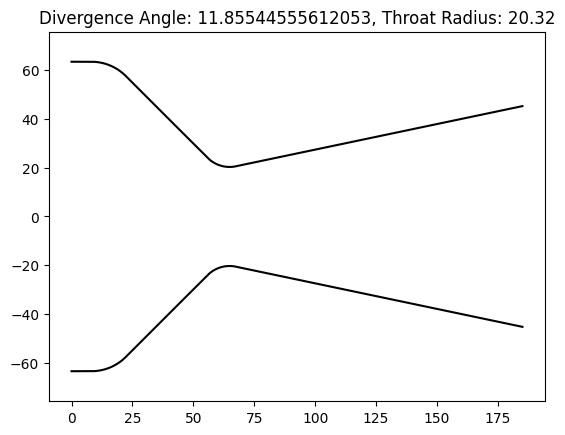

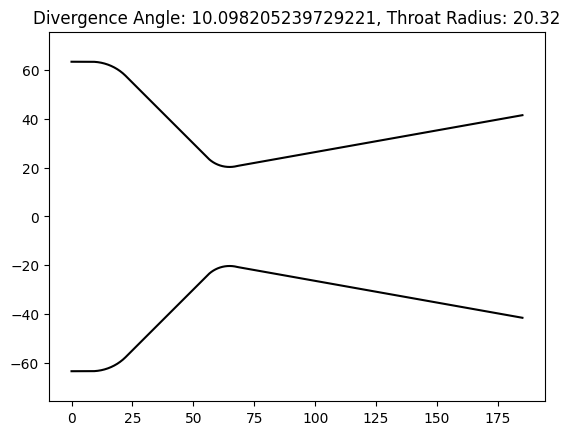

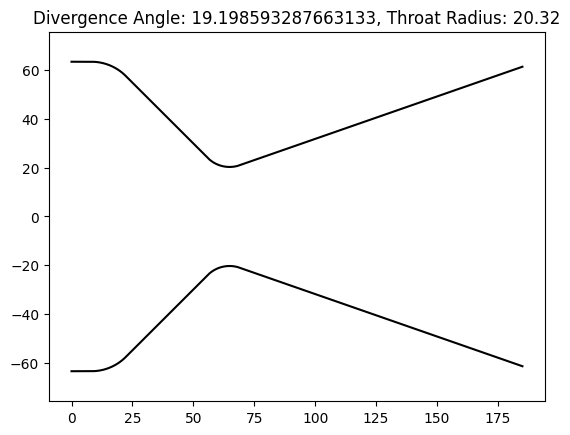

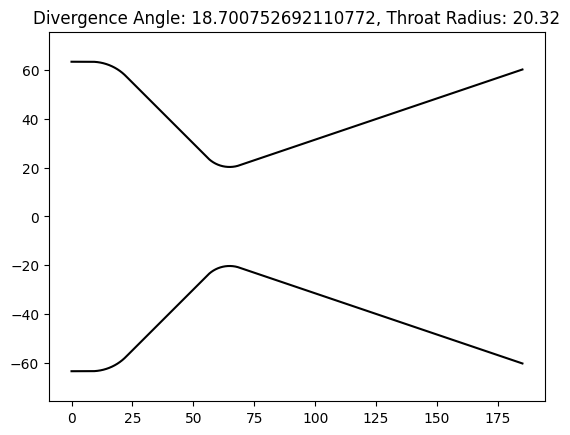

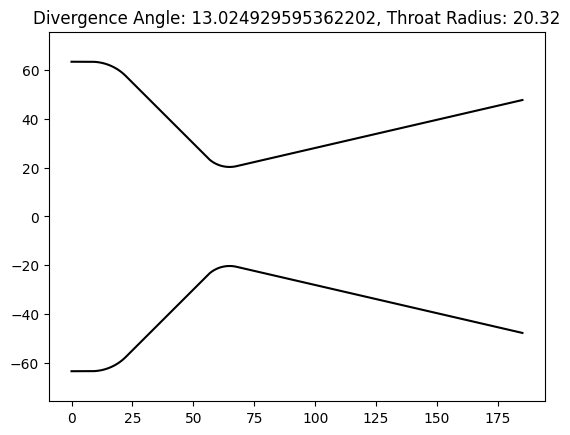

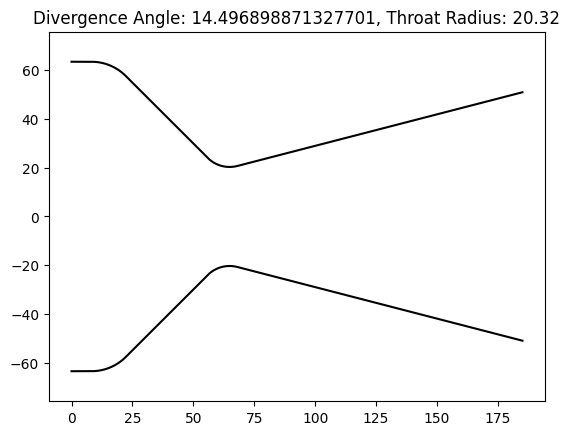

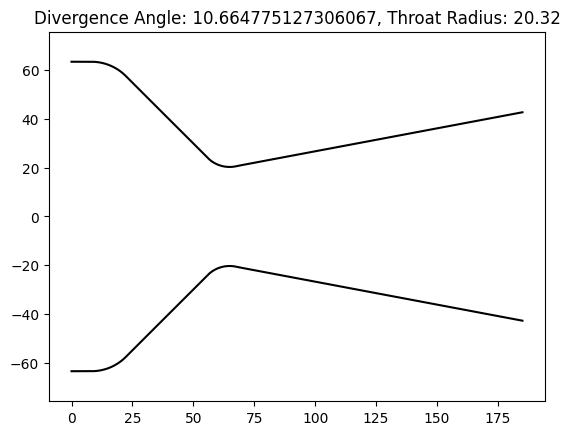

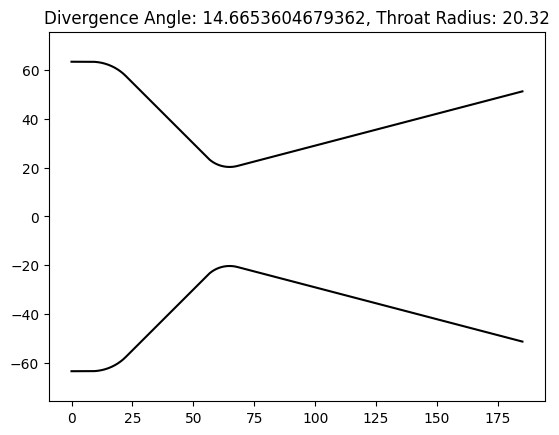

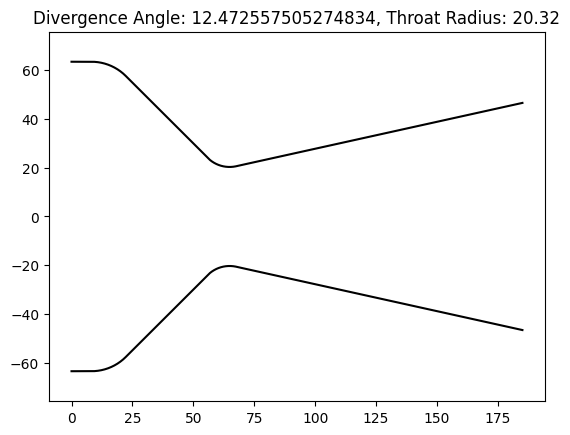

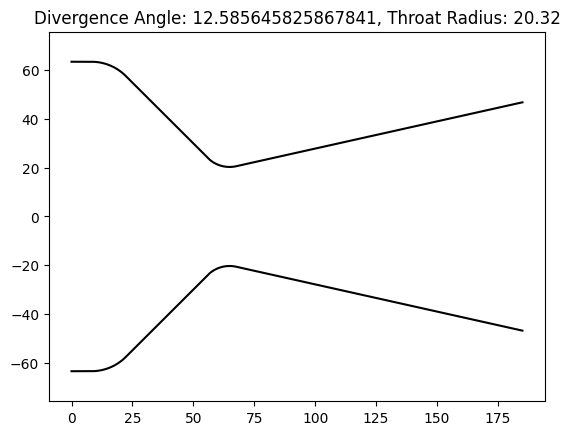

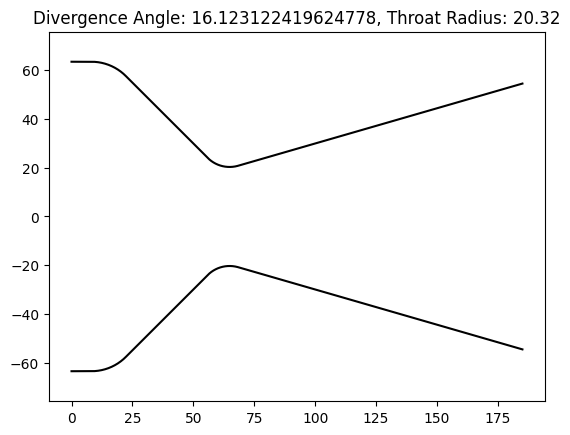

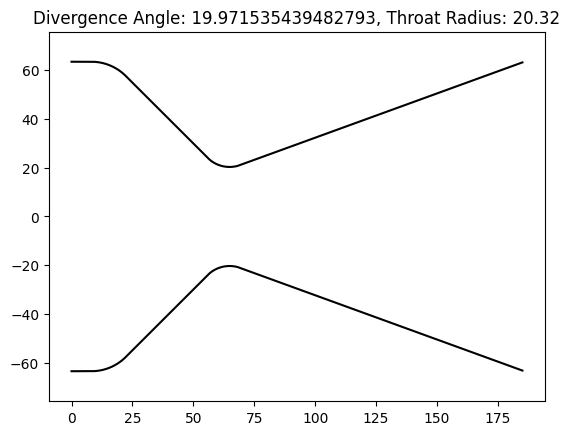

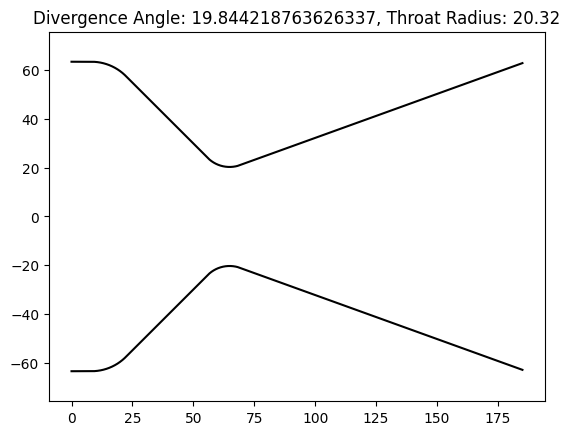

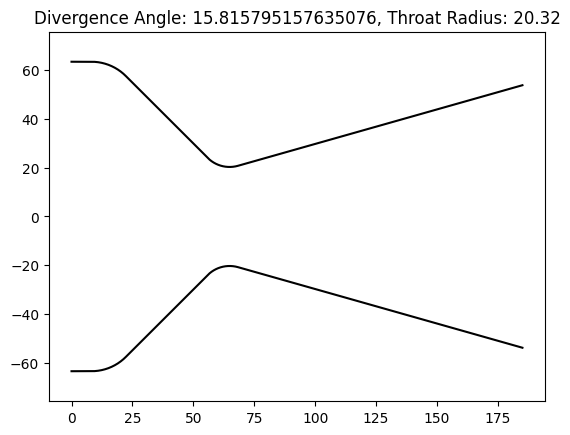

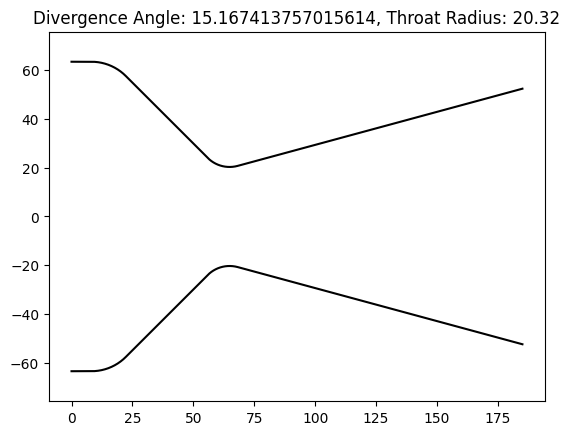

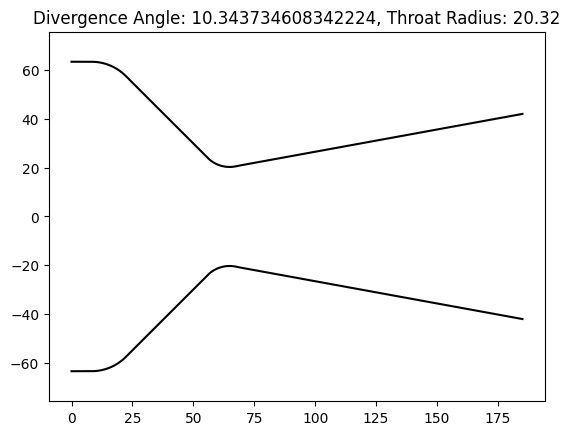

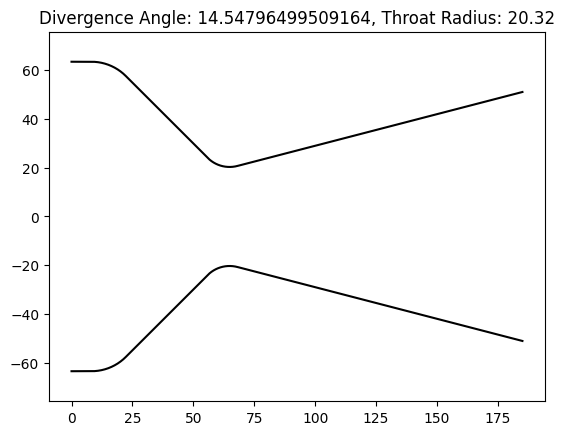

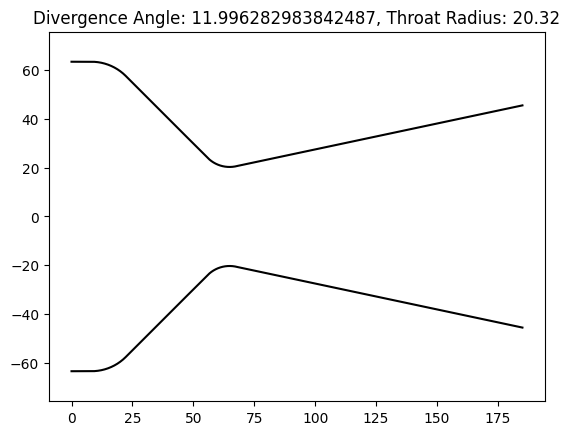

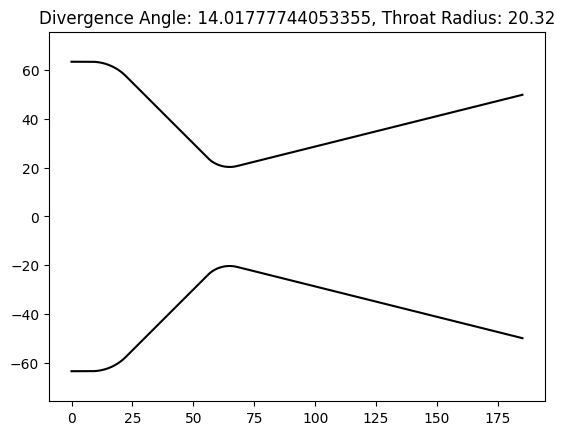

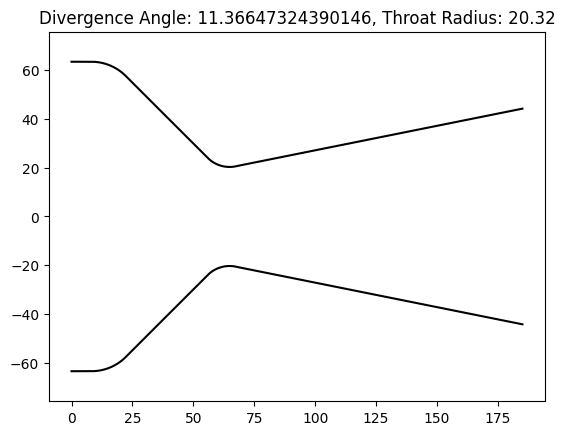

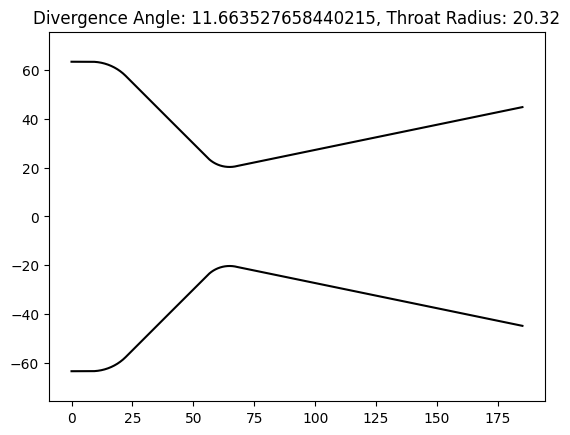

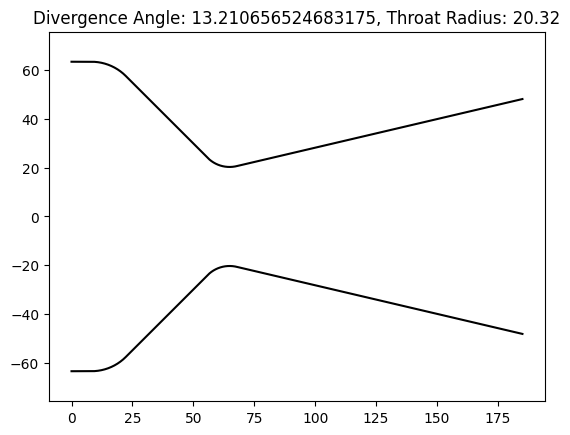

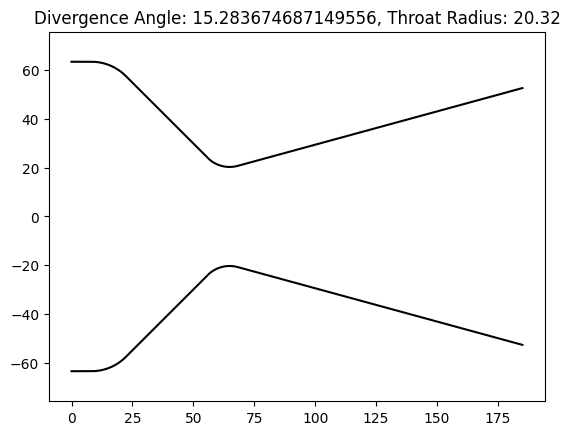

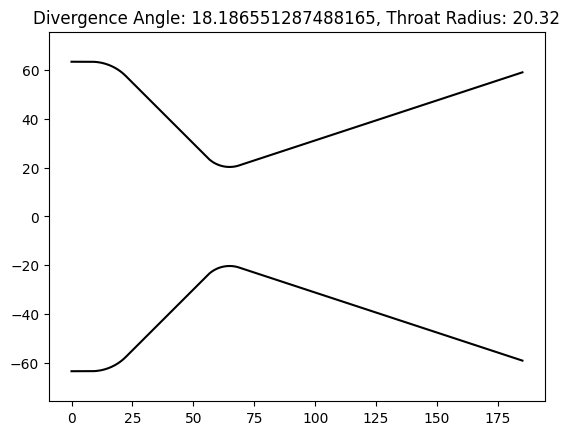

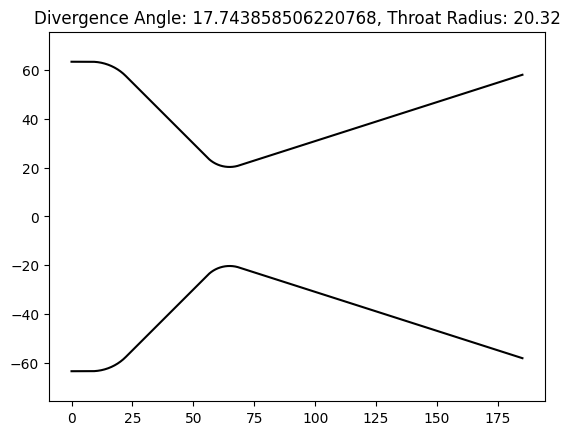

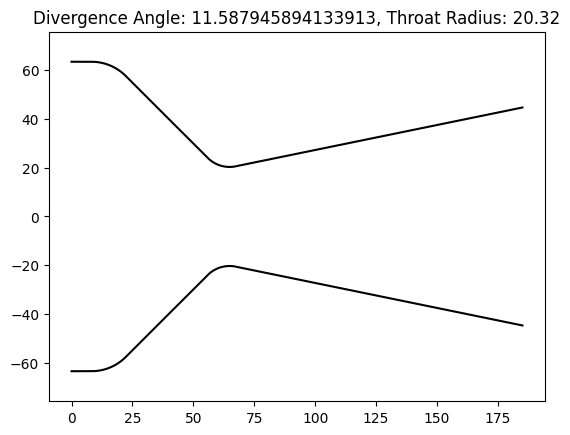

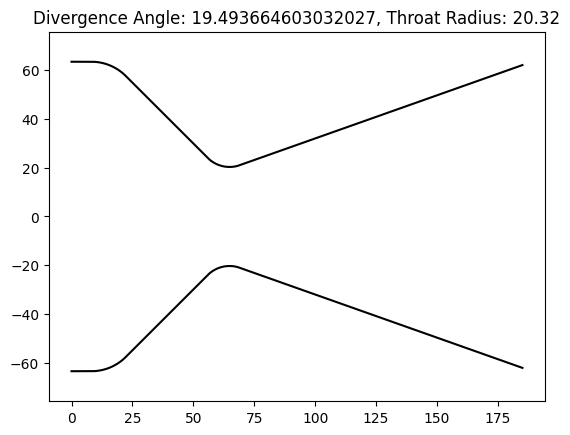

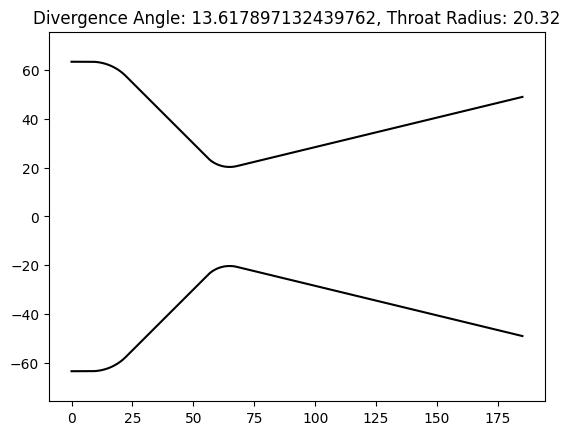

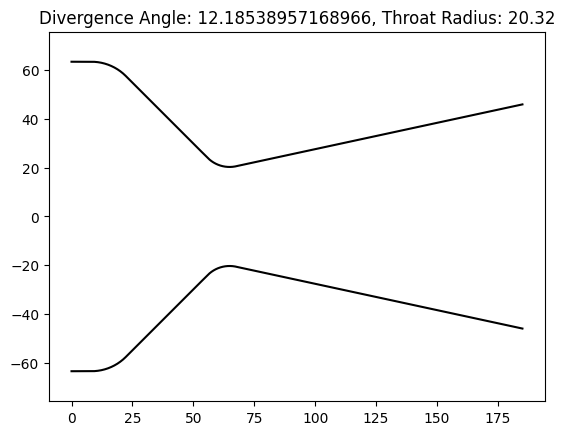

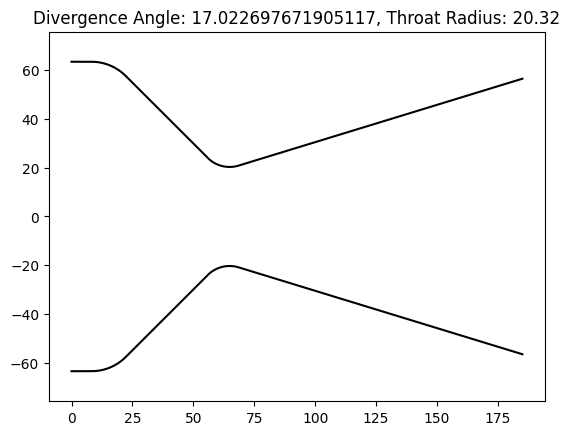

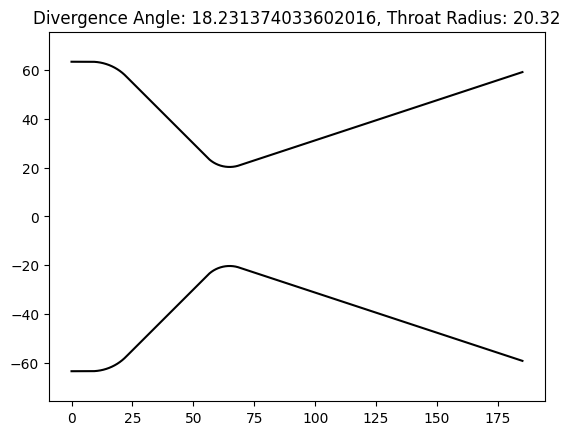

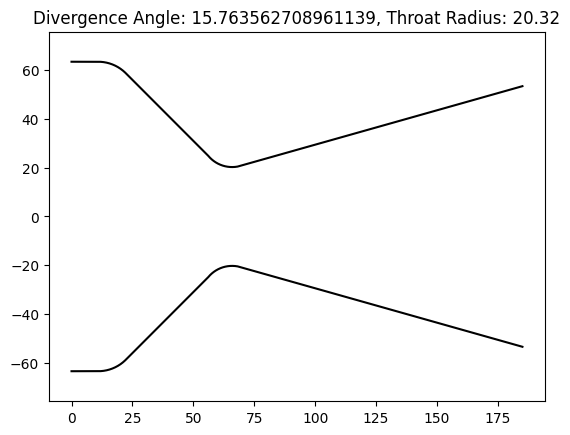

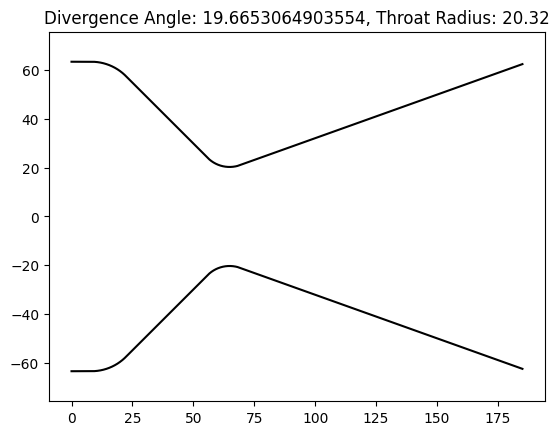

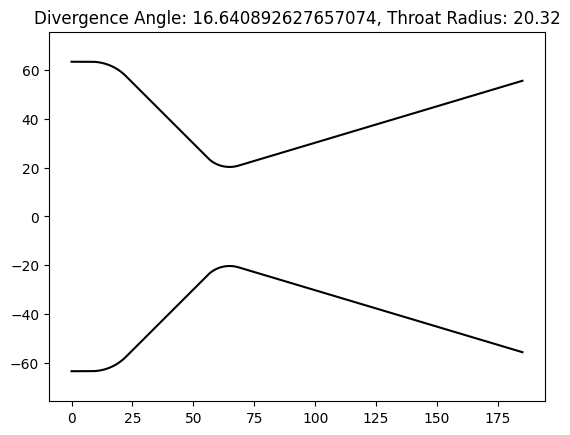

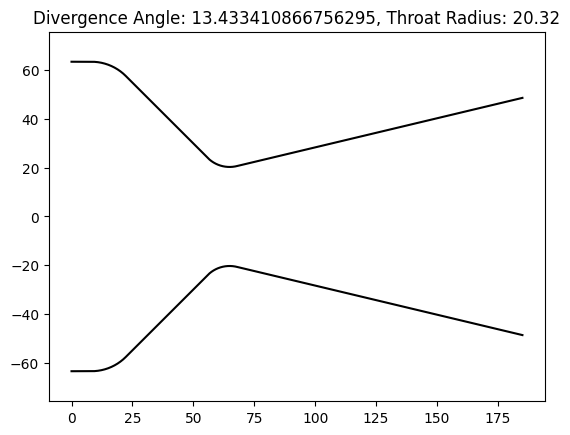

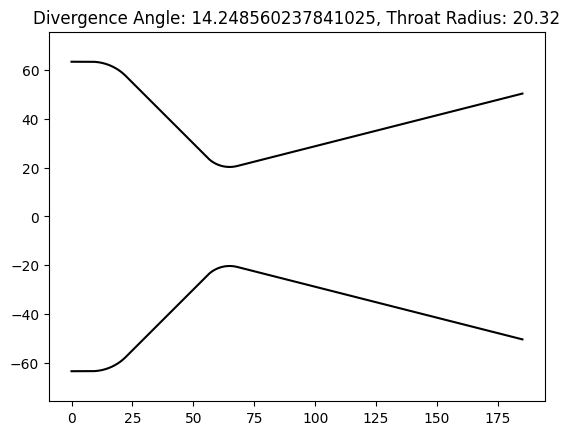

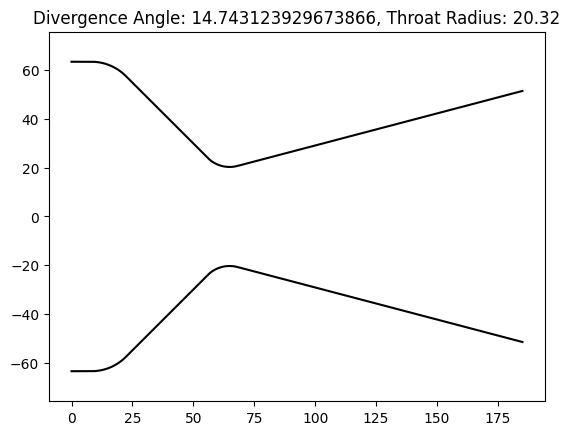

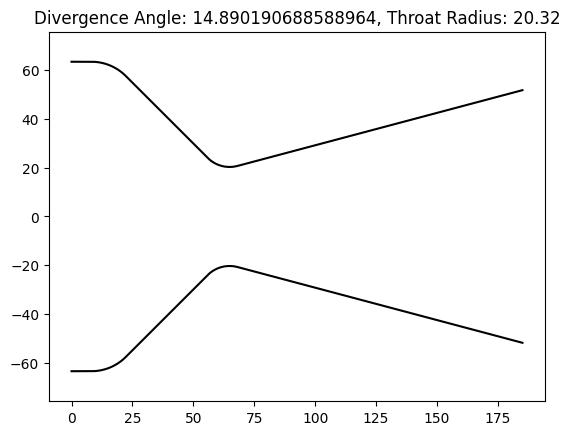

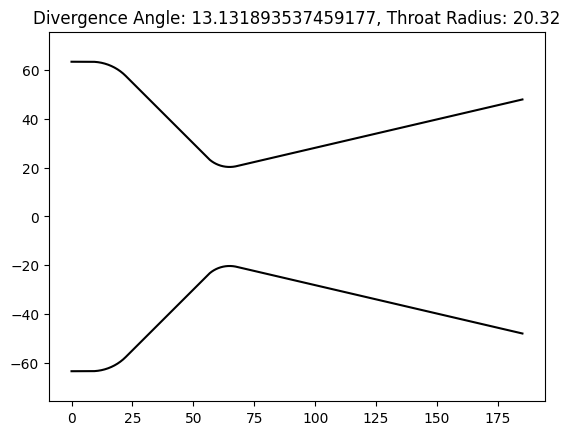

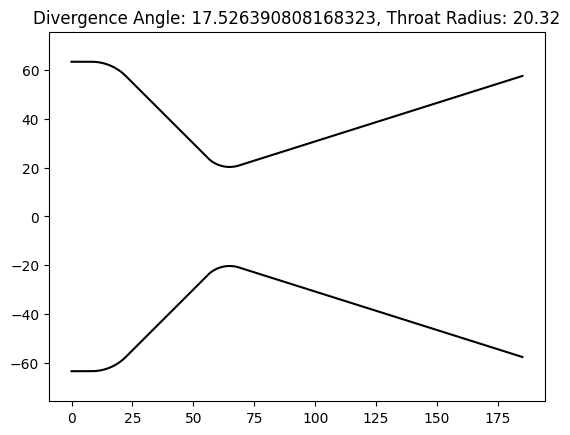

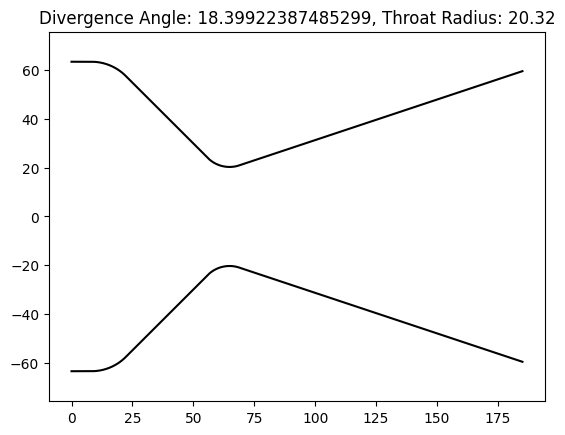

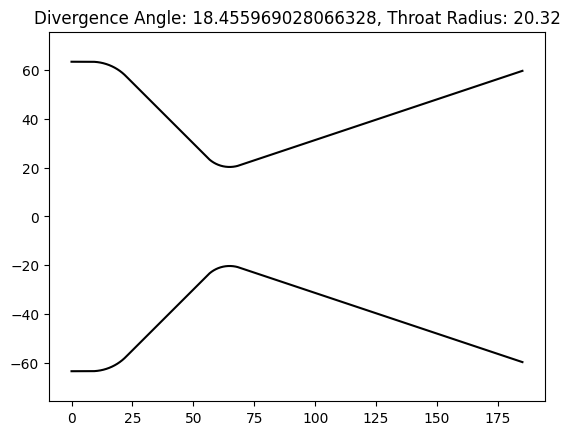

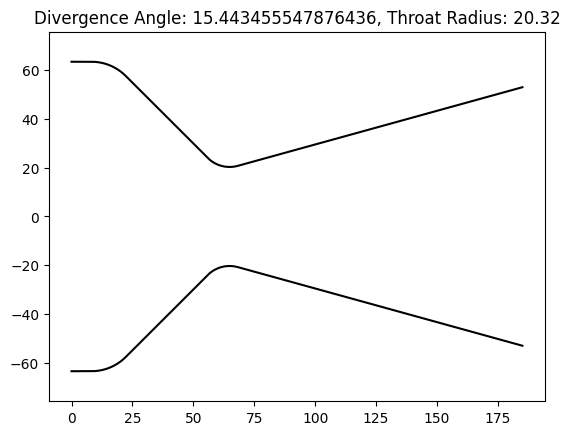

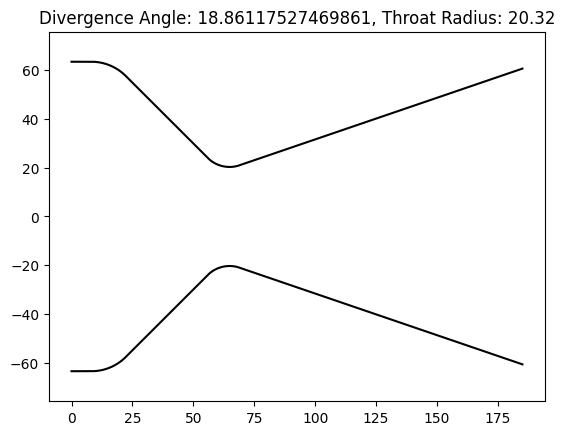

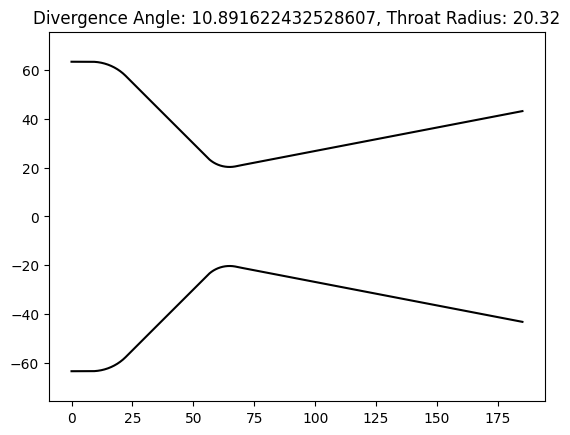

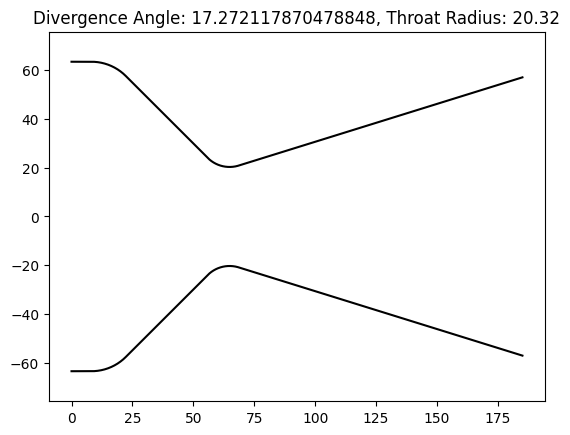

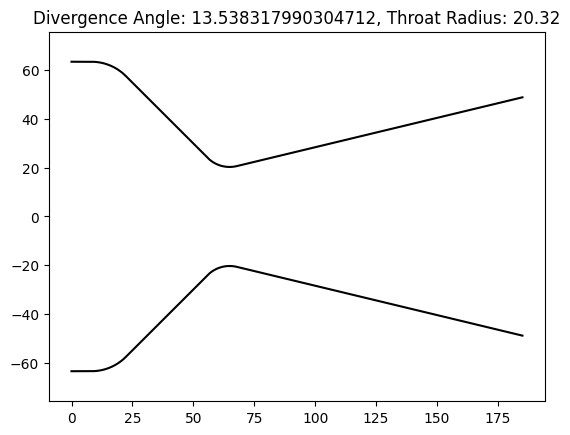

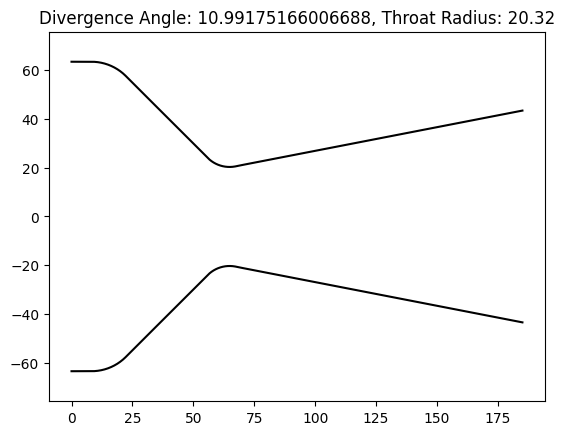

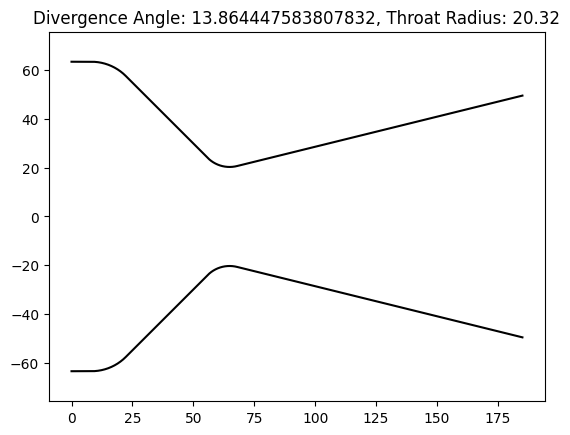

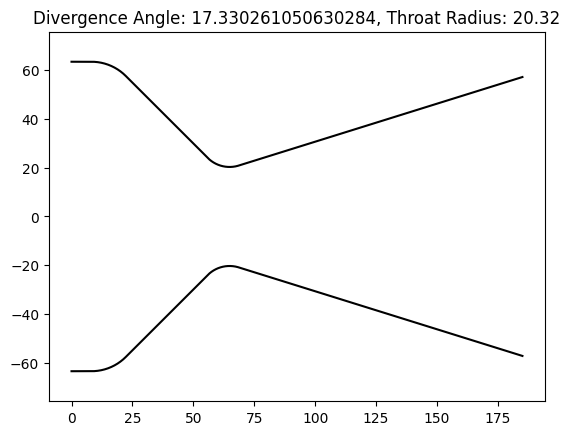

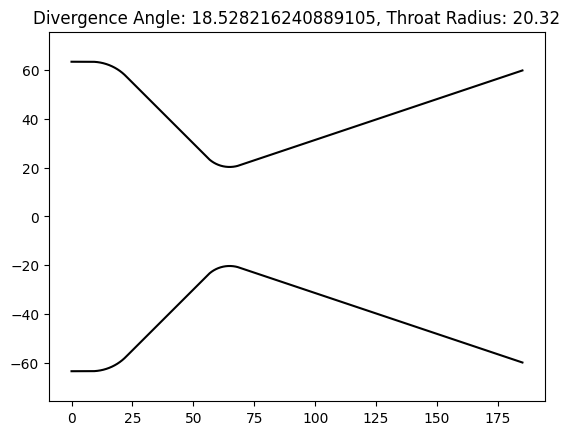

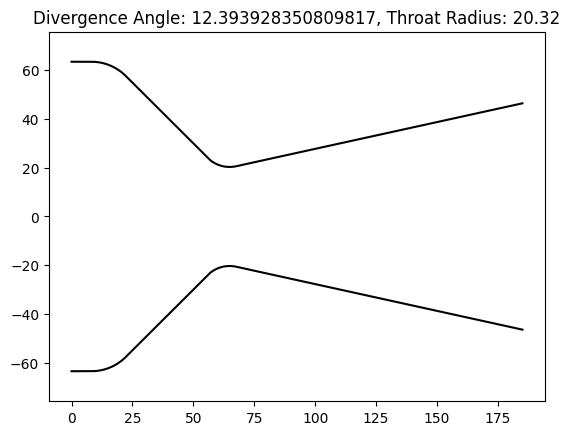

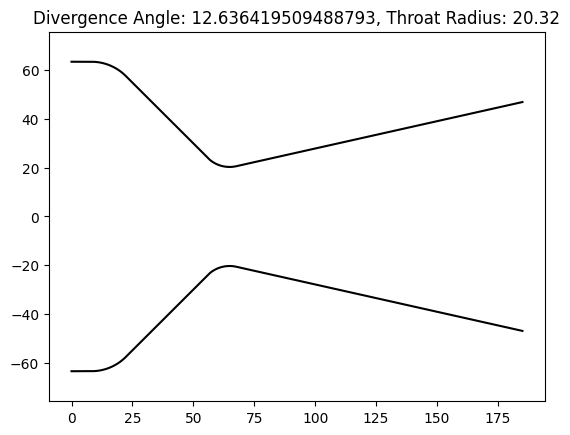

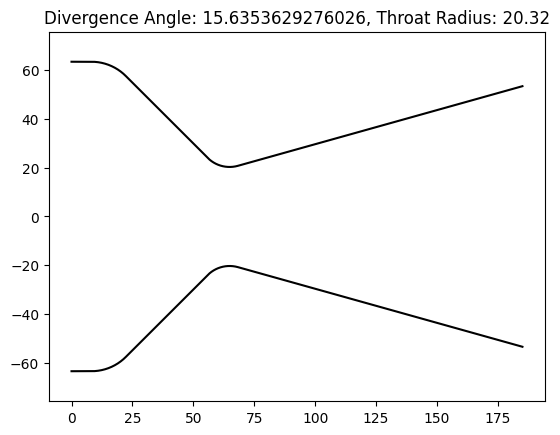

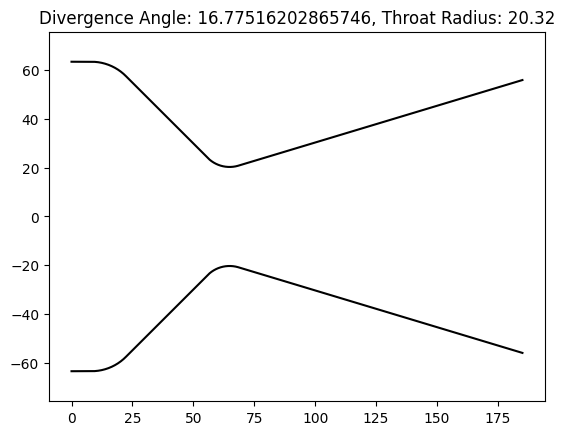

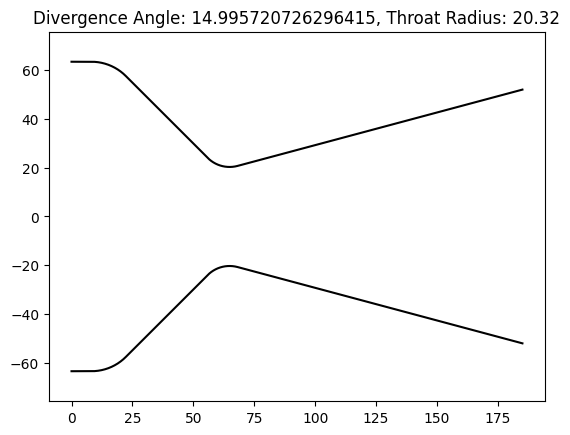

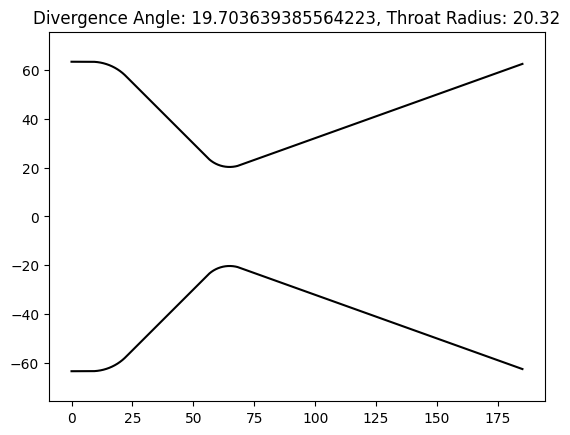

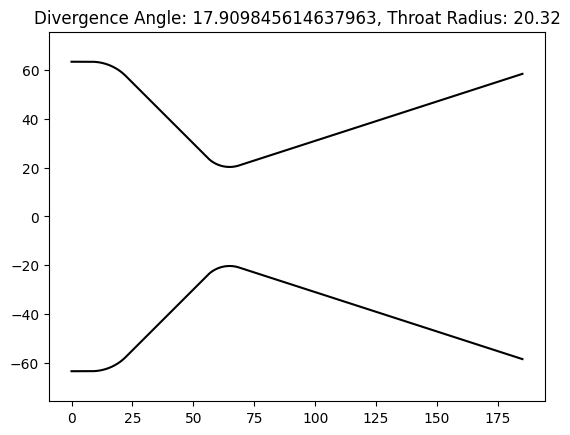

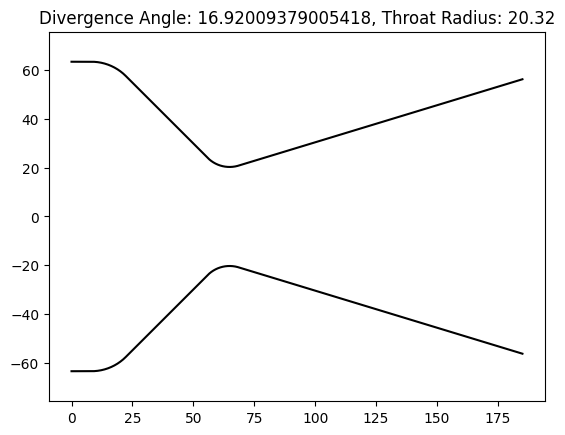

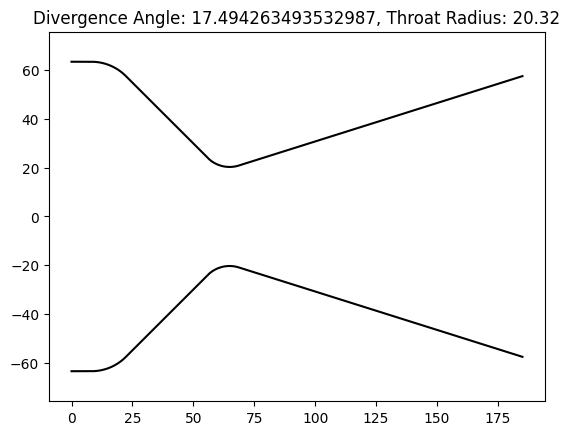

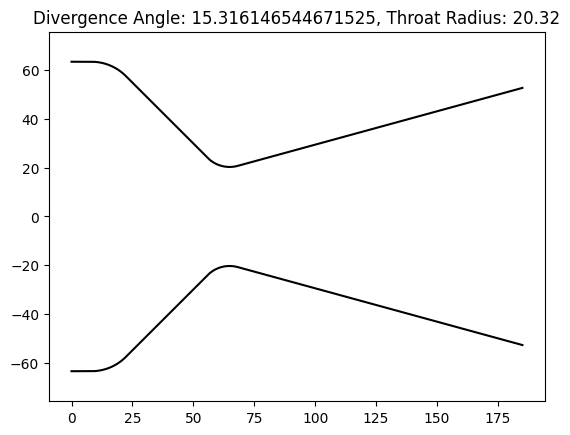

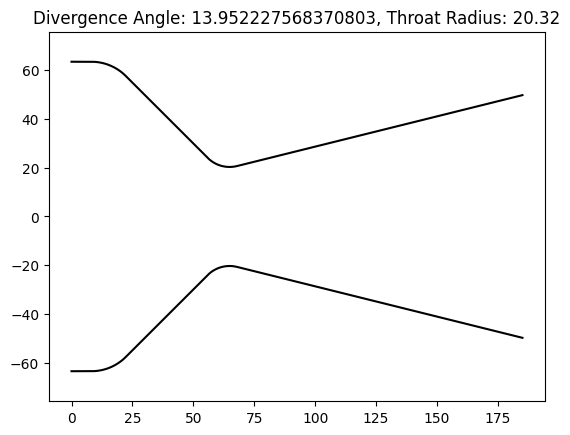

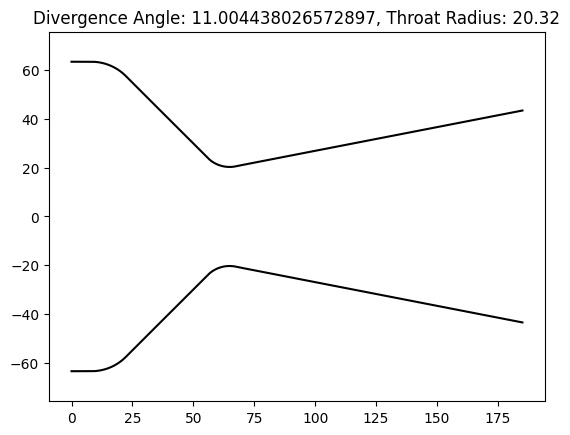

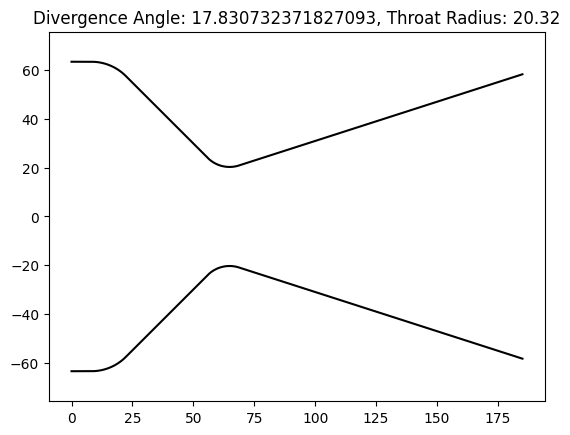

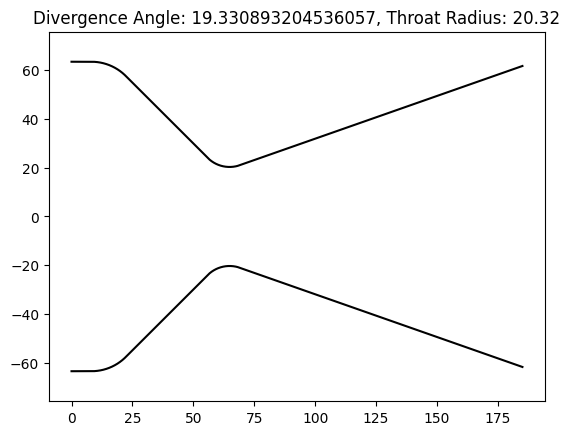

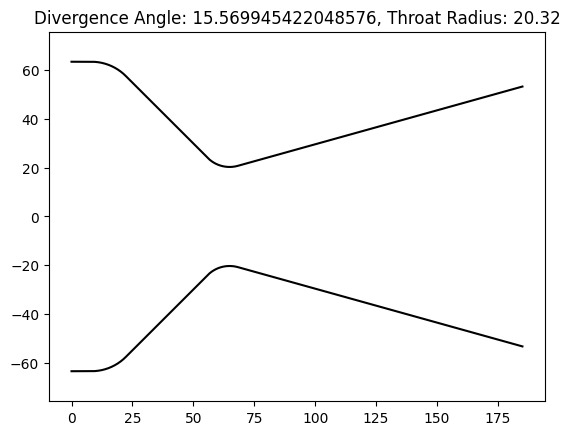

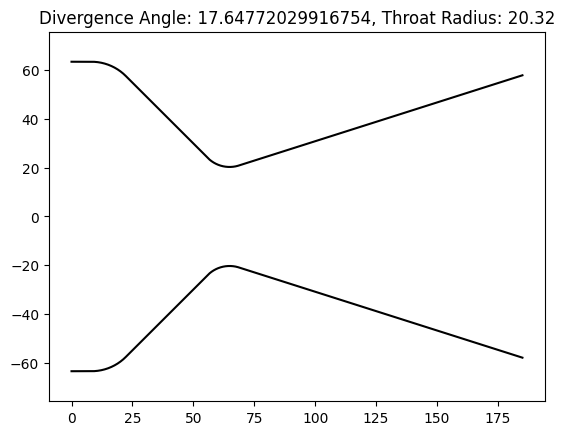

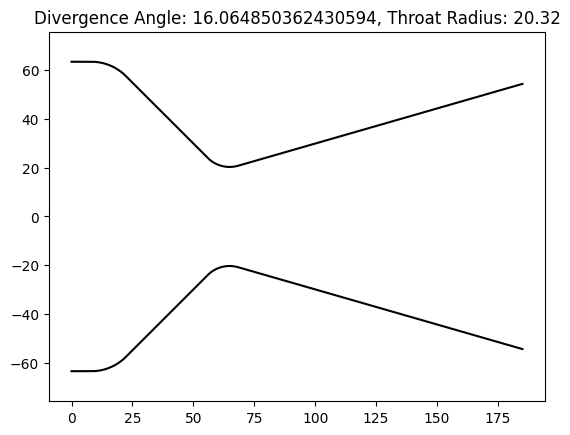

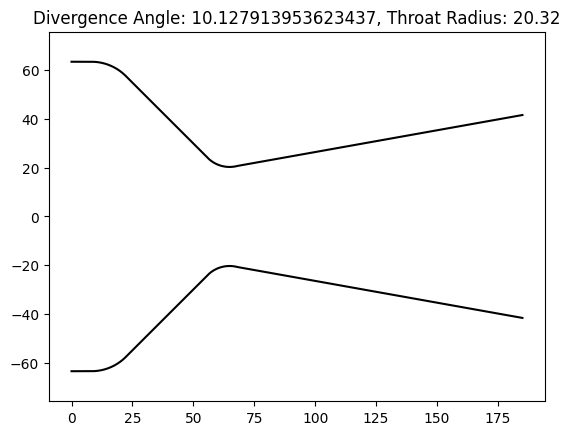

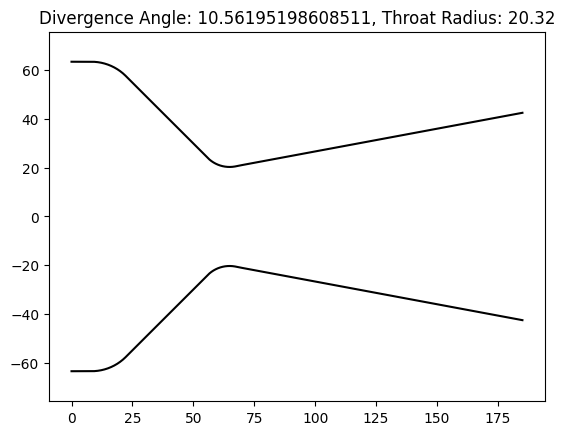

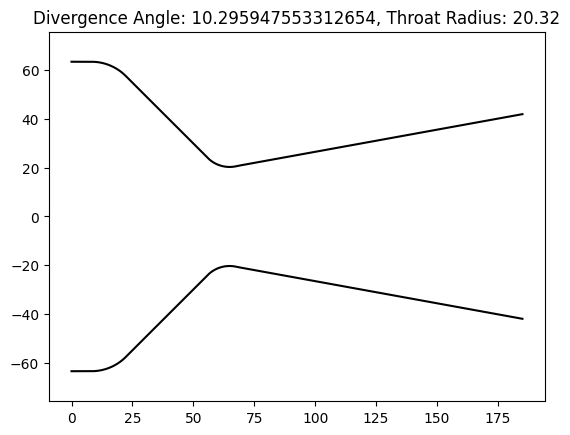

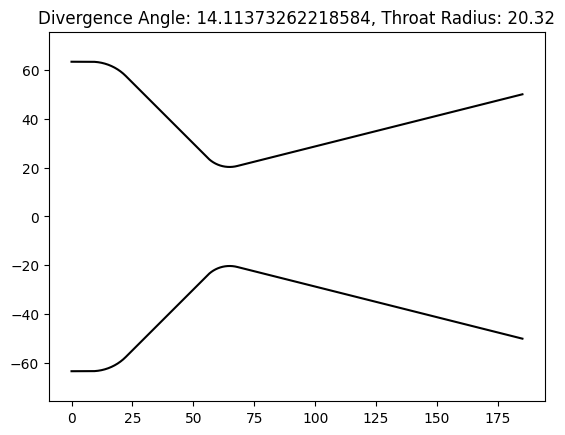

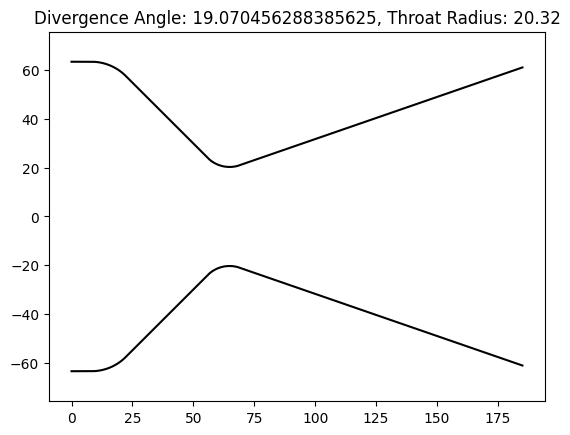

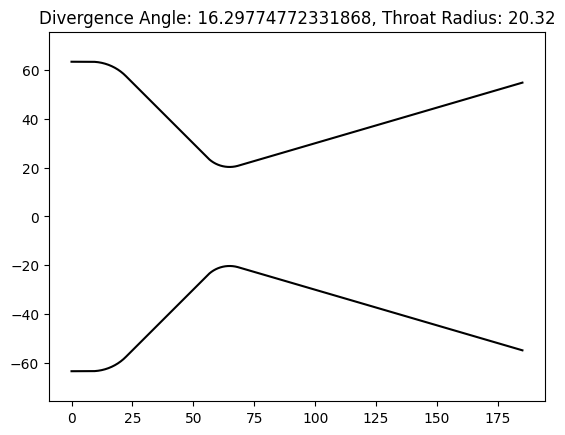

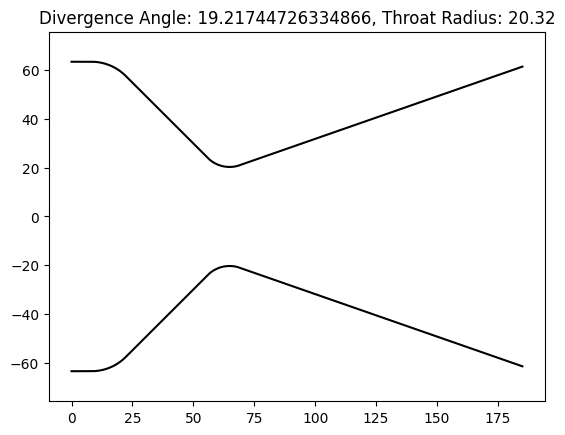

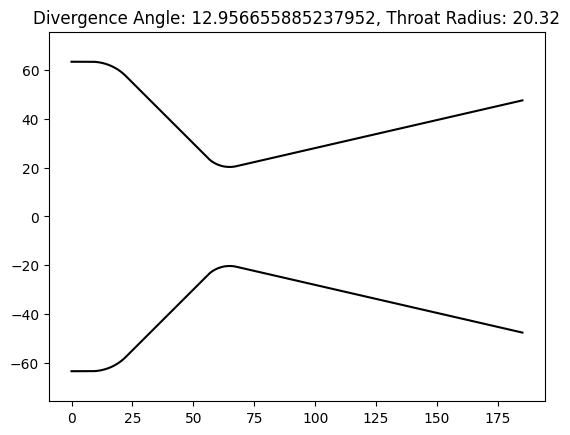

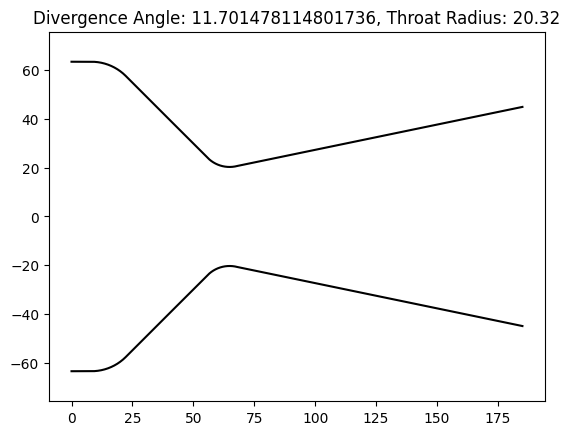

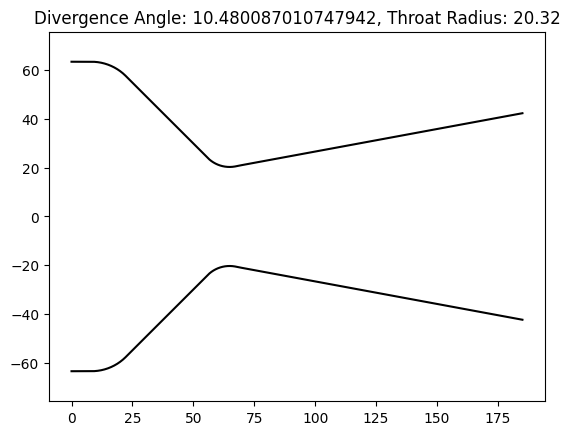

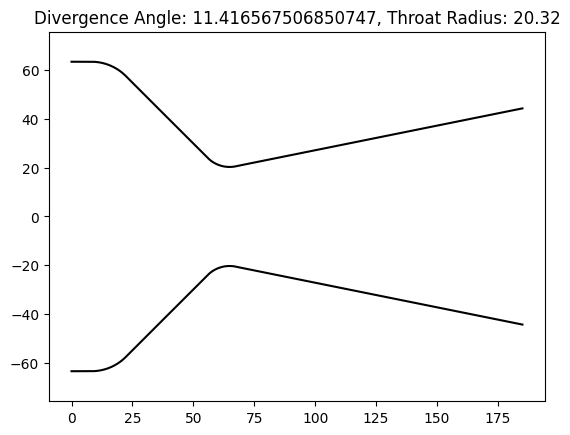

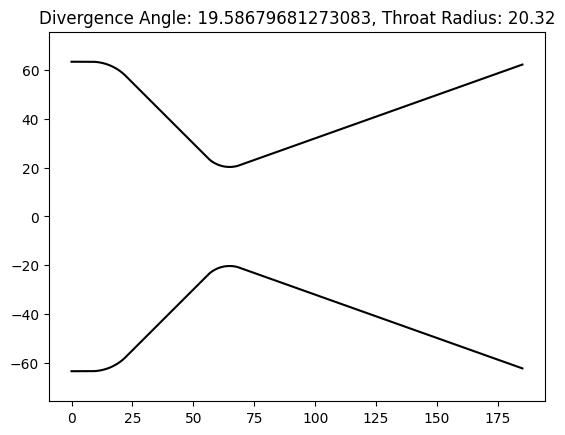

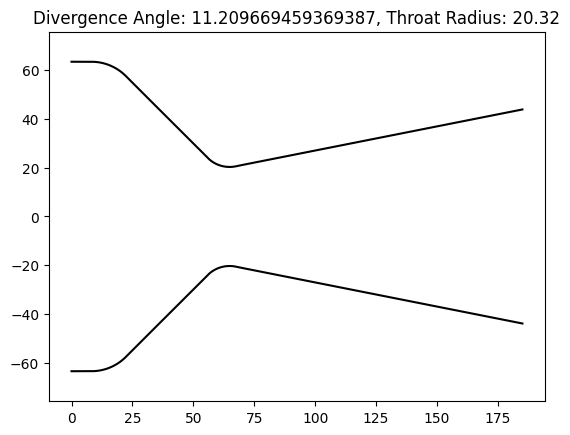

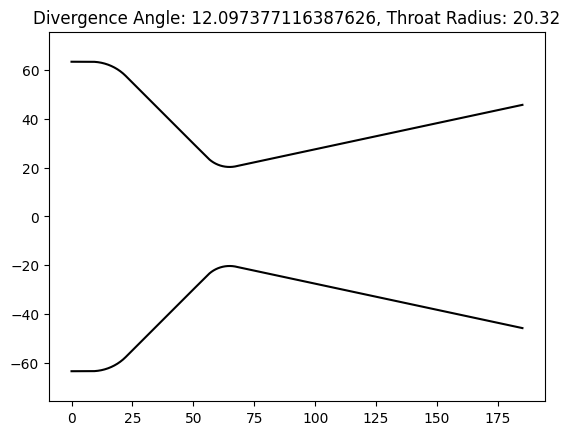

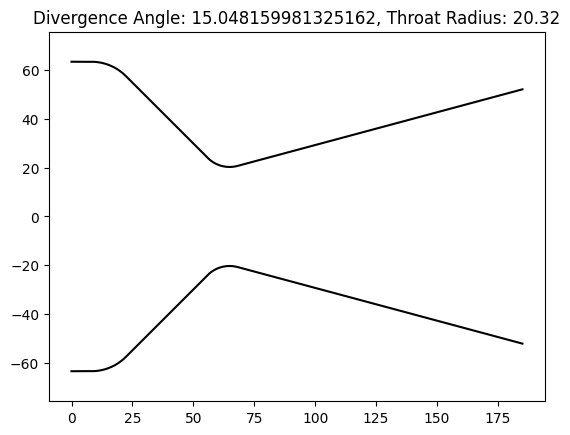

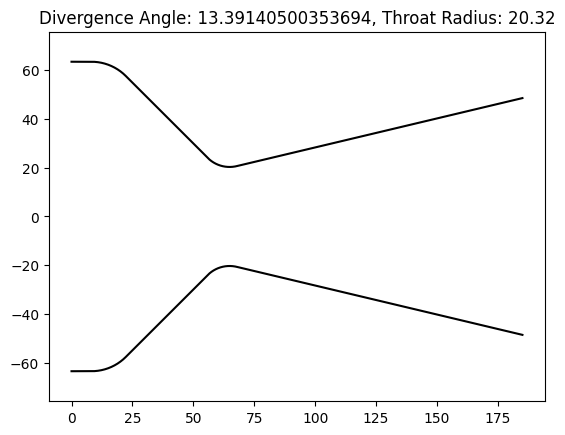

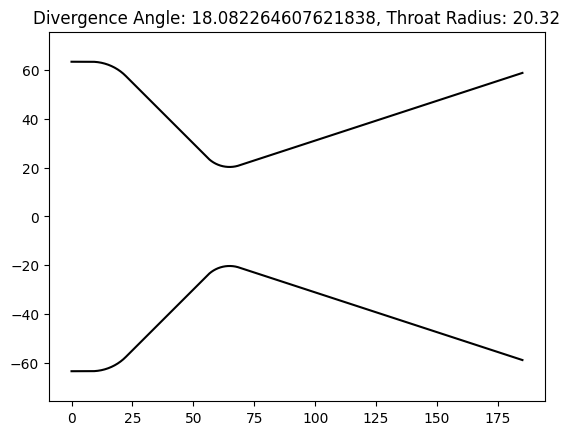

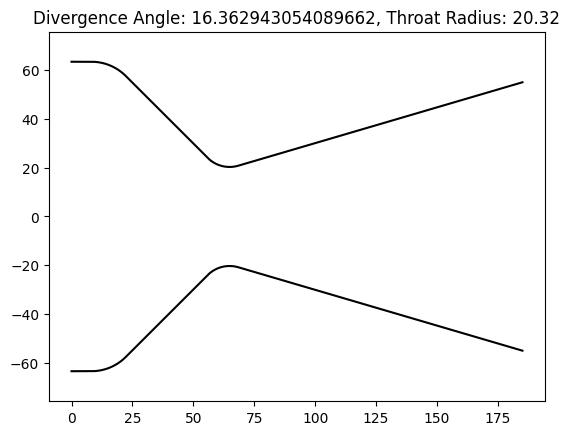

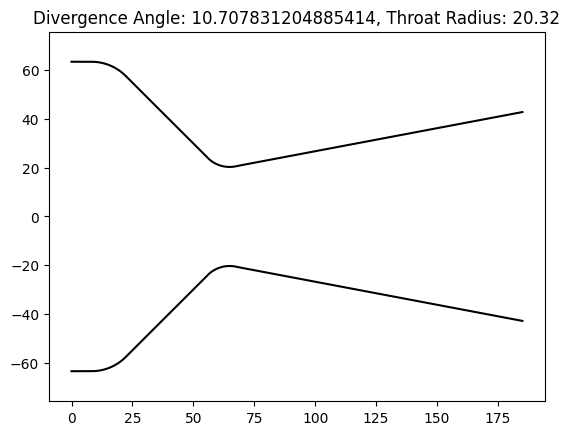

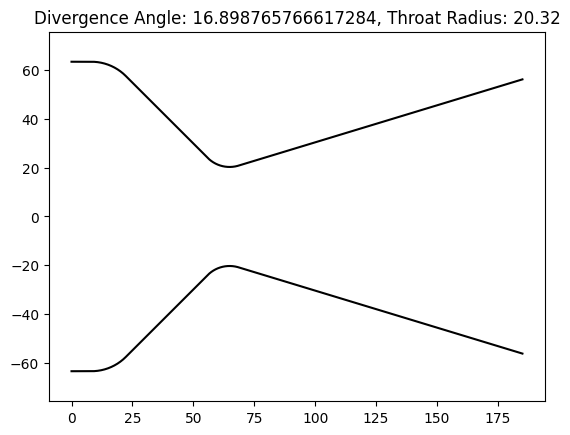

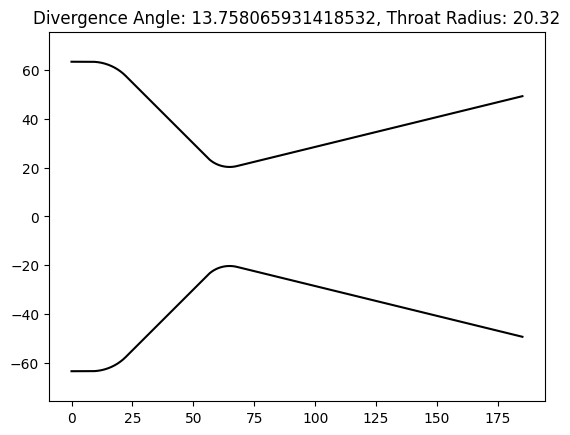

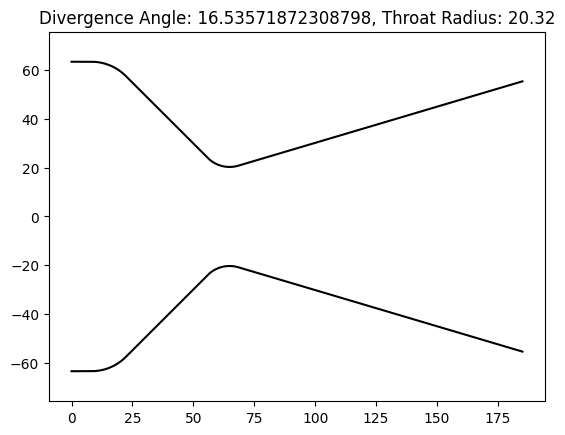

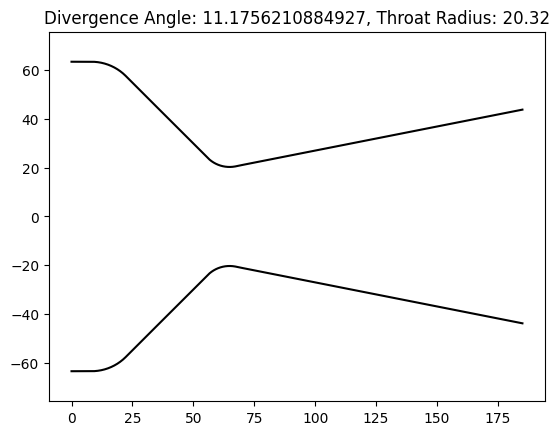

In [48]:
import matplotlib.pyplot as plt

for da, tr in zip(full_df['divergence_angle'], full_df['throat_radius']):
    nozzle = BackNozzleCAD(
        divergence_angle=da,
        throat_radius=tr,
    )

    points = nozzle.get_points(1000)
    xn, rn = points[:, 0], points[:, 1]

    plt.title(f'Divergence Angle: {da}, Throat Radius: {tr}')
    plt.plot(xn, rn, c='k')
    plt.plot(xn, -rn, c='k')
    plt.axis('equal')
    plt.show()

In [6]:
from frog.doe import DoEProcessor

doe_processor = DoEProcessor(
    doe_file='./data/doe_lhs_2D.csv')

doe_processor.run_design_point(0)

Info    : Running '/home/ppiper/Dropbox/xps/doctorate/repositories/pyqode/pyqode/src/gmsh /home/ppiper/Dropbox/xps/doctorate/repositories/frog/examples/data/2D/0/mesh/nozzle.geo -0 -2 -format su2 -o /home/ppiper/Dropbox/xps/doctorate/repositories/frog/examples/data/2D/0/mesh/nozzle.su2' [Gmsh 4.9.1, 1 node, max. 1 thread]
Info    : Started on Wed Nov 15 15:43:44 2023
Info    : Reading '/home/ppiper/Dropbox/xps/doctorate/repositories/frog/examples/data/2D/0/mesh/nozzle.geo'...
Info    : Done reading '/home/ppiper/Dropbox/xps/doctorate/repositories/frog/examples/data/2D/0/mesh/nozzle.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.00132629s, CPU 0.005882s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Transfinite)
Info    : Done meshing 2D (Wall 0.000982566s, CPU 0.002483s)
Info    : 2824 nodes 2952 elements
